# Project Report: Predicting Airbnb Listing Prices
Group: Paul Bullier

    1. Objective and Overall Approach (Preamble)
My goal for this project is to predict the log of Airbnb listing prices. I first tarted working with simple regressions, then tested the RandomForestRegressor model, manually selecting the columns and parameters to use.

However, this method produced mixed results (I was able to reach a maximum R² of 0.53). I therefore decided to use XGBoost Regressor as the main algorithm, a tree-based boosting model known for its strong performance, especially in Kaggle competitions and in cases where tabular datasets are very large, as is the case here.



In [2]:
# -*- coding: utf-8 -*-
""" 
Main script for Airbnb price prediction using XGBoost
"""

import pandas as pd                     
import numpy as np                      
import matplotlib.pyplot as plt          
import seaborn as sns                    

from sklearn.model_selection import train_test_split            
from sklearn.pipeline import Pipeline                           
from sklearn.impute import SimpleImputer                        
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer                   
from sklearn.metrics import mean_squared_error, r2_score        

from xgboost import XGBRegressor

# Loading the dataset
print("Loading data...")
train_df = pd.read_csv(r'C:\Users\paulb\Downloads\Airbnb\airbnb_train.csv')
test_df = pd.read_csv(r'C:\Users\paulb\Downloads\Airbnb\airbnb_test.csv')
print(f"Data successfully loaded. Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# Display a sample of the training data
print("Preview of training data:")
train_df.sample(3)




Loading data...
Data successfully loaded. Train shape: (22234, 28), Test shape: (51877, 27)
Preview of training data:


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
1405,6382314,4.382027,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",2,1.0,Real Bed,flexible,True,...,NaN,33.871753,-118.370763,Luxury Private Bedroom w/ Bathroom,Redondo Beach,0,NaN,90278,1.0,1.0
21255,16163018,5.293305,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",""Air conditionin...",6,1.0,Real Bed,flexible,True,...,2017-05-29,40.717305,-73.991083,Lower East Side Apartment,Lower East Side,1,100.0,10002,3.0,3.0
3929,9107450,6.109248,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",""Air conditionin...",8,1.5,Real Bed,strict,True,...,2017-09-24,40.687780,-73.955603,Historic Brooklyn Townhouse w/Big Yard - Sleeps 8,Bedford-Stuyvesant,19,97.0,11238,4.0,4.0


    2. Qualitative Exploration of the Data

Let’s start with a simple overview to examine the values taken by the log of the price.
The log of the price appears to follow a bell-shaped distribution, with a peak around 4.5, which corresponds to a price of approximately 90 dollars.
Most prices fall between 3 and 7, which corresponds to values between 20 and 1000 dollars.

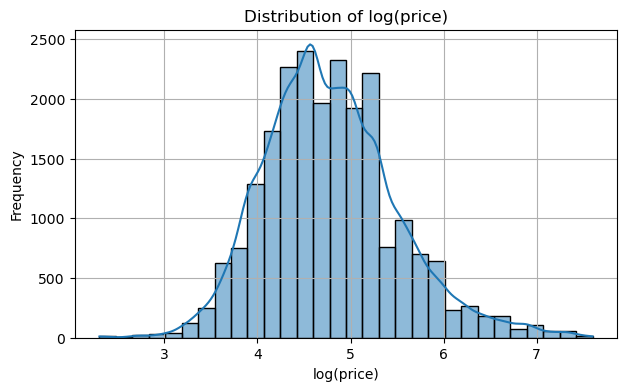

My initial assumption was that the price mainly depends on the type of accommodation.
And this is indeed the case: shared rooms are much cheaper
than entire homes.

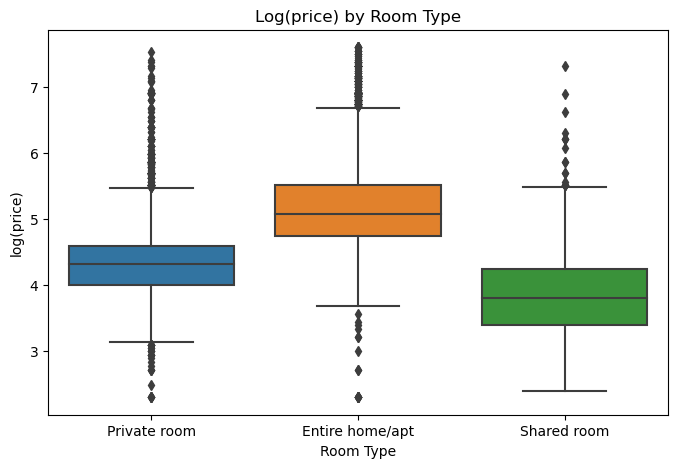

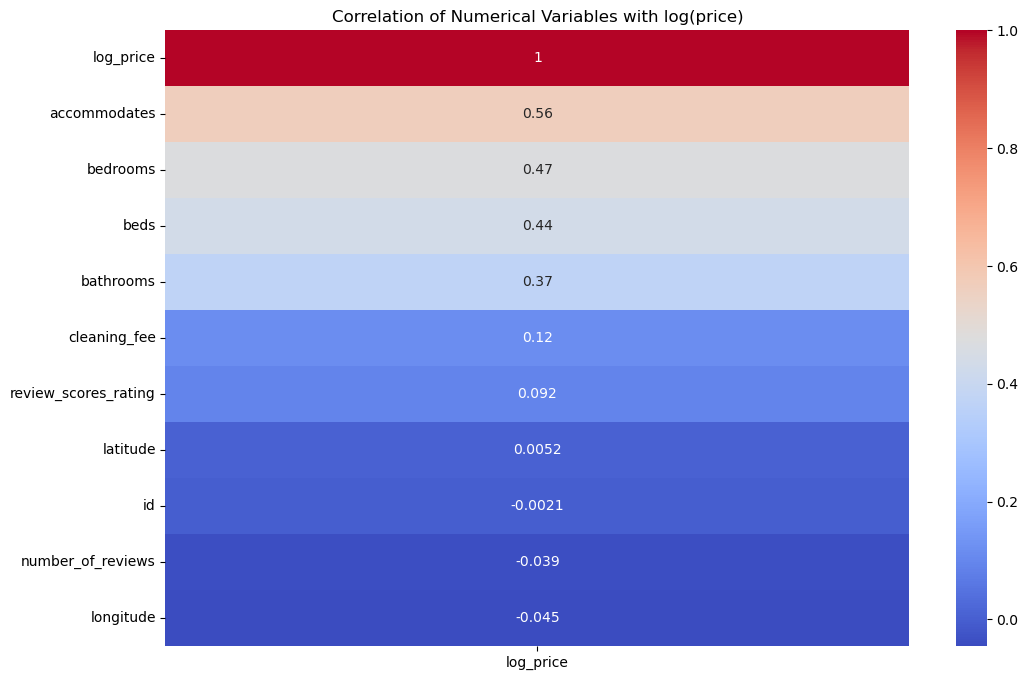

In [4]:
# Price (log) depending on room type
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='room_type', y='log_price')

plt.title("Log(price) by Room Type")
plt.xlabel("Room Type")
plt.ylabel("log(price)")
plt.show()


# Numerical feature correlations
corr = train_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr[['log_price']].sort_values(by='log_price', ascending=False),
    annot=True,
    cmap='coolwarm'
)

plt.title("Correlation of Numerical Variables with log(price)")
plt.show()


I therefore carried out a correlation analysis
to identify the variables that have the greatest influence on price.
The strongest correlation is observed with the variable accommodates (correlation of 0.56),
which is completely logical:
the more people a listing can accommodate, the more its price tends to increase.

I also examined which amenities were the most important to consider—
that is, those for which there is a large price difference
between listings that include the amenity and those that do not.

Out of curiosity, I wanted to see where the listings were located,
so I plotted latitude and longitude on a graph.
We observe that the accommodations are mainly concentrated in a few regions,
particularly around the area (latitude = 34, longitude = –118),
which corresponds to California.

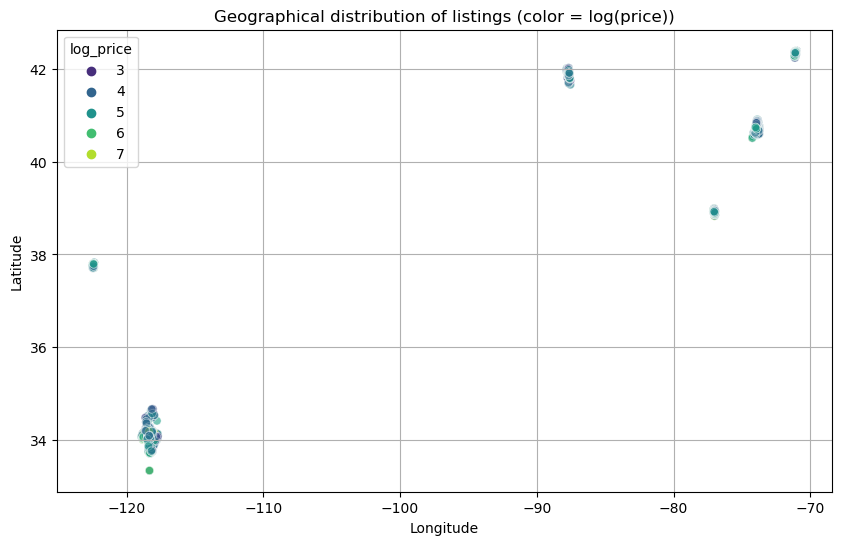


Key points I believe are important for the log-price prediction model:
- Coordinates (latitude, longitude): kept because location has a strong impact on price
- 'room_type': kept because it has a significant influence on pricing
- 'name': transformed into 'name_length' to capture indirect textual information
- 'amenities': transformed into binary columns (has_wifi, has_pool, etc.)
- 'last_review': converted into month and year to exploit temporal patterns in reviews


In [6]:
# Geographic distribution of listings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='longitude', y='latitude', hue='log_price', palette='viridis', alpha=0.6)
plt.title("Geographical distribution of listings (color = log(price))")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='log_price')
plt.grid(True)
plt.show()

# Key insights derived from exploratory data analysis
print("\nKey points I believe are important for the log-price prediction model:")
print("- Coordinates (latitude, longitude): kept because location has a strong impact on price")
print("- 'room_type': kept because it has a significant influence on pricing")
print("- 'name': transformed into 'name_length' to capture indirect textual information")
print("- 'amenities': transformed into binary columns (has_wifi, has_pool, etc.)")
print("- 'last_review': converted into month and year to exploit temporal patterns in reviews")


In [7]:
"""
Log-Price Prediction Section
""" 

# 2. Data preparation function
def prepare_data(df):
    df = df.copy()  # Work on a copy of the original data

    # Amenities to check
    amenities_to_check = ['Wifi', 'Pool', 'Air Conditioning', 'Kitchen', 'Heating', 'TV', 'Washer', 'Dryer', 'Gym']
    for a in amenities_to_check:
        df[f'has_{a.lower().replace(" ", "_")}'] = df['amenities'].str.contains(a, case=False, na=False).astype(int)

    # Length of listing title
    df['name_length'] = df['name'].str.len().fillna(0)

    # Does the listing have any reviews?
    df['has_reviews'] = df['number_of_reviews'] > 0

    # Convert last review date
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['last_review_year'] = df['last_review'].dt.year.fillna(0)
    df['last_review_month'] = df['last_review'].dt.month.fillna(0)

    # Group rare neighborhoods into "Other"
    if 'neighbourhood' in df.columns:
        top_neigh = df['neighbourhood'].value_counts().nlargest(15).index
        df['neighbourhood'] = df['neighbourhood'].where(df['neighbourhood'].isin(top_neigh), 'Other')

    return df

print("Preparing data...")
train_df = prepare_data(train_df)

# 3. Separate features (X) and target (y)
X = train_df.drop(columns=['log_price', 'id', 'name', 'amenities', 'last_review'], errors='ignore')
y = train_df['log_price']

# Split into training (95%) and validation (5%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)
print(f"Training data: {X_train.shape[0]} rows")
print(f"Validation data: {X_val.shape[0]} rows")

# 4. Prepare transformations
num_features = X_train.select_dtypes(include=np.number).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

# Log transformation for skewed features
skewed_features = ['number_of_reviews']
for col in skewed_features:
    if col in num_features:
        X_train[col] = np.log1p(X_train[col])
        X_val[col] = np.log1p(X_val[col])

# Transformation pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_features)
])

train_df.sample(3)  # Display 3 random samples


Preparing data...
Training data: 21122 rows
Validation data: 1112 rows


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,has_kitchen,has_heating,has_tv,has_washer,has_dryer,has_gym,name_length,has_reviews,last_review_year,last_review_month
14941,16740225,4.442651,Apartment,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",2,1.0,Real Bed,flexible,False,...,1,1,0,1,1,0,29,True,2016.0,9.0
1515,18463640,5.298317,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",Kitchen,""Sm...",1,1.0,Real Bed,flexible,False,...,1,1,1,1,1,0,21,False,0.0,0.0
10245,8488816,3.555348,Apartment,Shared room,"{Essentials,""translation missing: en.hosting_a...",1,1.0,Real Bed,flexible,True,...,0,0,0,0,0,0,39,True,2017.0,1.0


    3. Data Preprocessing
a. Feature Enrichment

The prepare_data() function adds relevant derived variables:
-Presence of specific amenities (Wifi, Pool, Air Conditioning, etc.),
-Length of the listing title (name_length),
-Presence or absence of reviews (has_reviews),
-Year and month of the last review, extracted after converting last_review,
-Simplification of neighborhoods: only the 15 most frequent ones are kept, and the others are grouped into an "Other" category.
This preprocessing step aims to provide the model with simple but meaningful indicators.

b. Handling Missing Values and Data Types

Numerical variables are imputed using the median and standardized with a StandardScaler,
while categorical variables are imputed with a constant and encoded using one-hot encoding (OHE).
This pipeline is integrated into a ColumnTransformer to simultaneously process the different types of columns.

c. Target and Feature Transformation

The model predicts log_price, i.e., the natural logarithm of the price,
in order to reduce variance and stabilize extreme values.
Additionally, some columns such as number_of_reviews, which are highly skewed,
are also transformed using a logarithmic scale.

Training the model...

Validation results:
RMSE: 0.3962
R²: 0.6851


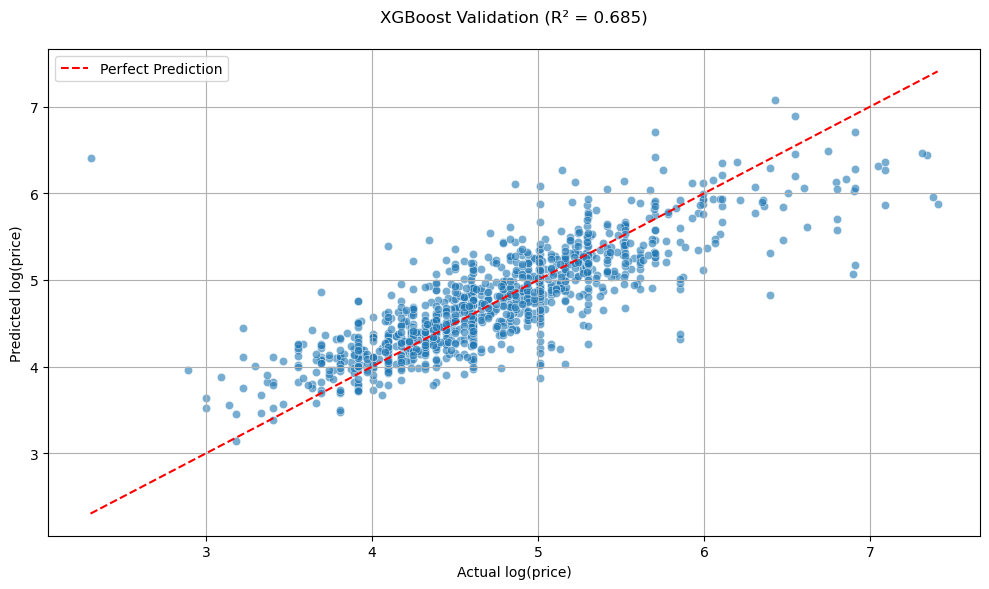

In [8]:
# 5. XGBoost model creation
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# 6. Model training
print("Training the model...")
model.fit(X_train, y_train)

# 7. Prediction on validation set
y_pred = model.predict(X_val)

# 8. Performance evaluation
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("\nValidation results:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# 9. Save validation predictions
results_val = pd.DataFrame({
    'id': train_df.loc[X_val.index, 'id'],
    'log_price_actual': y_val,
    'log_price_predicted': y_pred,
    'difference': np.abs(y_val - y_pred)
})
results_val.to_csv('validation_predictions_xgb.csv', index=False)

# 10. Results visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_price_actual', y='log_price_predicted', data=results_val, alpha=0.6)
plt.plot([results_val['log_price_actual'].min(), results_val['log_price_actual'].max()],
         [results_val['log_price_actual'].min(), results_val['log_price_actual'].max()],
         'r--', label='Perfect Prediction')
plt.title(f"XGBoost Validation (R² = {r2:.3f})", pad=20)
plt.xlabel('Actual log(price)')
plt.ylabel('Predicted log(price)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('validation_plot_xgb.png')
plt.show()


    4.Model Training

a. Train–Validation Split

The training dataset is divided into:
-95% for training,
-5% for validation,
in order to evaluate the model’s ability to generalize.

b. XGBoost Model

The XGBoost model is configured with:
-500 trees,
-maximum depth of 7,
-learning rate of 0.1,
-80% subsampling (both row and column subsampling) to reduce overfitting.

The model is wrapped inside a Pipeline along with the preprocessor, ensuring a clean integration of all preprocessing and learning steps.

    5.Performance Evaluation

Predictions are evaluated on the validation set using two metrics:

RMSE (Root Mean Squared Error) and R² (coefficient of determination)

The results obtained are:

RMSE: ~0.39

R²: ~0.69, which is significantly better than my first models, which barely exceeded 0.45.

These results surpass the initial target (R² ≈ 0.63), showing that the model is capable of capturing most of the variance in log-price from the available features.
Nevertheless, it would certainly be possible to achieve even better performance with more training data and by further refining the preprocessing steps and model tuning.

My visualization of the results shows a good alignment around the ideal perfect-prediction line in red.

In [9]:
# 11. PREDICTION ON TEST DATA
print("\nPredicting on test data...")

# Prepare test data
test_df_prepared = prepare_data(test_df)

# Ensure the same columns as in training
test_df_prepared = test_df_prepared[X_train.columns]

# Make predictions
test_predictions = model.predict(test_df_prepared)

# Create results file
results_test = pd.DataFrame({
    'id': test_df['Unnamed: 0'],  # Use the index column as id
    'log_price': test_predictions
})

# Save to CSV
results_test.to_csv('test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'")
print(f"Number of predictions: {len(results_test)}")
print("\nPreview of predictions:")
print(results_test.head())

print("\nAll tasks completed successfully!")



Predicting on test data...
Test predictions saved to 'test_predictions.csv'
Number of predictions: 51877

Preview of predictions:
         id  log_price
0  14282777   4.842090
1  17029381   5.888589
2   7824740   4.885946
3  19811650   5.946587
4  12410741   4.521002

All tasks completed successfully!


5. Final Prediction and Export

The test set is processed using the same pipeline as the training data. Special attention is paid to ensuring that the columns are aligned with those from the training set to avoid errors during prediction. The predictions are then exported to a file named test_predictions.csv.



6. Conclusion

I was able to learn quite a lot, whether it was about data preparation, visualizations, or training a model like XGBoost. It was also interesting to see that even with a few simple adjustments, it was possible to improve the results.

Possible future improvements could include:

- Exploring alternative models (LightGBM, CatBoost)  
- Creating new temporal features (seasonality, time since the last booking)  
- Conducting more thorough hyperparameter tuning using Bayesian optimization or GridSearchCV

Paul BULLIER
